In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "Datasets/VanilaDataset"
train_patterns = pd.read_csv(file_path + "/train_patterns_with_symbols.csv")
test_patterns = pd.read_csv(file_path + "/test_patterns_with_symbols.csv" )

In [3]:
train_patterns

,Symbol,Chart Pattern,BullishBearish,Start,End,Industry,Pattern_Length
0,GIS,"Triangle, symmetrical",0,2024-12-18,2025-01-02,Food Processing,15
1,TXN,"Double Top, Adam and Adam",0,2025-01-15,2025-01-23,Semiconductor,8
2,BSET,"Flag, high and tight",1,2020-06-25,2020-08-20,Furn/Home Furnishings,56
3,NOVT,"Double Bottom, Adam and Adam",0,2024-02-21,2024-02-27,Precision Instrument,6
4,IPAR,"Double Bottom, Eve and Adam",0,2024-05-01,2024-05-08,Toiletries/Cosmetics,7
...,...,...,...,...,...,...,...
2373,CE,Head-and-shoulders bottom,1,2022-02-24,2022-03-15,Chemical (Basic),19
2374,KMT,Head-and-shoulders top,0,2025-01-06,2025-01-30,Metal Fabricating,24
2375,BERY,"Double Top, Adam and Adam",-1,2020-02-06,2020-02-21,Packaging and Container,15
2376,MUR,"Double Top, Adam and Adam",0,2023-04-03,2023-04-11,Petroleum (Integrated),8


In [4]:
test_patterns

,Symbol,Chart Pattern,BullishBearish,Start,End,Industry,Pattern_Length
0,NUS,"Double Bottom, Eve and Adam",0,2023-01-19,2023-01-31,Toiletries/Cosmetics,12
1,CLS,"Double Bottom, Adam and Adam",0,2024-03-11,2024-03-19,Electronics,8
2,ADTN,"Triangle, symmetrical",0,2023-06-16,2023-07-10,Telecom. Equipment,24
3,ADTN,Head-and-shoulders bottom,1,2020-09-09,2020-10-02,Telecom. Equipment,23
4,NSP,"Double Bottom, Adam and Adam",0,2023-05-16,2023-05-31,Human Resources,15
...,...,...,...,...,...,...,...
590,RGLD,"Double Top, Adam and Adam",0,2024-10-21,2024-10-29,Metals and Mining (Div.),8
591,MRK,"Double Bottom, Eve and Adam",0,2024-08-07,2024-08-14,Drug,7
592,IRM,"Double Bottom, Adam and Adam",0,2025-01-28,2025-02-03,Industrial Services,6
593,CBT,"Double Top, Adam and Adam",0,2024-11-25,2024-12-04,Chemical (Diversified),9


In [5]:
# geth the 1st row of the test_patterns 
row = test_patterns.iloc[0]
# convert to date time
row['Start'] = pd.to_datetime(row['Start'])
print (row['Start'])
print(row['Start'] - pd.to_timedelta(5, unit='D'))

2023-01-19 00:00:00
2023-01-14 00:00:00


C:\Users\gwiku\AppData\Local\Temp\ipykernel_53692\3529229644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['Start'] = pd.to_datetime(row['Start'])


# Preparing the Test Data Segments


In [6]:
pattern_encoding = {'Double Top, Adam and Adam': 0, 'Triangle, symmetrical': 1, 'Double Bottom, Eve and Adam': 2, 'Head-and-shoulders top': 3, 'Double Bottom, Adam and Adam': 4, 'Head-and-shoulders bottom': 5, 'Flag, high and tight': 6, 'Cup with handle': 7}
pattern_encoding_reversed = {v: k for k, v in pattern_encoding.items()}
extra_days = 100

# create a new empty dataframe with Seg_ID, Seg_Start , Seg_End columsn + the same columns as the test_patterns
columns = ['Seg_ID', 'Seg_Start', 'Seg_End'] + list(test_patterns.columns)
# create an empty dataframe
test_pattern_segment_wise = pd.DataFrame(columns=columns)


# set the path to the folder containing the data
path = 'Datasets/OHLC data'

In [7]:
# add a row to test_pattern_segment_wise
def add_row_to_test_pattern_segment_wise(row,seg_id, start, end):
    global test_pattern_segment_wise
    row['Seg_ID'] = seg_id
    row['Seg_Start'] = start
    row['Seg_End'] = end
    test_pattern_segment_wise = test_pattern_segment_wise.append(row, ignore_index=True)

In [8]:
lable_df = pd.DataFrame(columns=['Pattern', 'Center', 'Width'])
# and give this 2 level indexes, level 0 called Instance and level 1 called Pattern_Id
lable_df.index = pd.MultiIndex.from_tuples([], names=['Instance', 'Pattern_Id'])

def add_to_lables( pattern, center, width ,instance, pattern_idx):
    global lable_df
    new_row = { 
                'Pattern': pattern,  # Example pattern
                'Center': center ,  # Example start date
                'Width': width # Example end date
            }
    # Define the MultiIndex for the new row
    new_index = pd.MultiIndex.from_tuples([(instance, pattern_idx)], names=['Instance', 'Pattern_Id'])

    # Create a DataFrame for the new row and append it to the original DataFrame
    new_df = pd.DataFrame([new_row], index=new_index, columns=lable_df.columns)
    lable_df = pd.concat([lable_df, new_df])

## Creating test data segments


Im trying to get test data segments with some surrounding data with a maximem possible number of teting data in a single segment while avoiding training data


In [9]:
import os
from tqdm import tqdm
segment_id = 0

# loop through the files in the folder
for filename in tqdm(os.listdir(path), desc="Processing files"):
        if filename.endswith('.csv'):
        # print(filename)
            OHCL_symbol_df = pd.read_csv(path + '/' + filename)
            # print(df.head())
            
            # convert the date columns to datetime
            OHCL_symbol_df['Date'] = pd.to_datetime(OHCL_symbol_df['Date'])
            
            max_available_date = OHCL_symbol_df['Date'].max()
            min_available_date = OHCL_symbol_df['Date'].min()
            
            name = os.path.splitext(filename)[0]
            
            # get the rows of pattern_labled_df where Symbol == name
            train_data_this_symbol = (train_patterns[train_patterns['Symbol'] == name]).copy()
            test_data_this_symbol = (test_patterns[test_patterns['Symbol'] == name]).copy()
            
            # reset the index of the dataframes
            train_data_this_symbol.reset_index(drop=True, inplace=True)
            test_data_this_symbol.reset_index(drop=True, inplace=True)
            
            # in test data create a new column ID and give it the same value as the index
            test_data_this_symbol['ID'] = test_data_this_symbol.index
            
            # print(test_data_this_symbol)
            
            
            # convert the date columns to datetime
            train_data_this_symbol['Start'] = pd.to_datetime(train_data_this_symbol['Start'])
            train_data_this_symbol['End'] = pd.to_datetime(train_data_this_symbol['End'])
            test_data_this_symbol['Start'] = pd.to_datetime(test_data_this_symbol['Start'])
            test_data_this_symbol['End'] = pd.to_datetime(test_data_this_symbol['End'])
            
            
            # 01. pick one test item
            # 02. get the left cut off date as the max of start date - 50 or the cthe end date of a train data point that has a end date between test start date and test start - 50
            # 03. get the right cut off date as the min of end date + 50 or the cthe start date of a train data point that has a start date between test end date and test end + 50
            # 04. get the tets data points that can fit in between the left and right cut off dates
            # 05. iterate the set of test items that is to the left of the selected one , as the new start date is the start date of the i th items start date and the end date is that + 100 + the length of the selcted item
            # 06. get the number of test items that fit between the segment in each iteration , and select the option that has the max number of test items
            # 07. get the wiggle room by the min start date of the test items that fit in the segment and the max end date of the test items that fit in the segment and try to randomise the start and end dates of the segment
            
            # get a list of randomly ordered test item indexes
            index_touple = list(range(len(test_data_this_symbol)))
            np.random.shuffle(index_touple)
            
            # 01. pick one test item
            
            for test_idx in index_touple:
                # get the test item
                test_item = test_data_this_symbol[test_data_this_symbol['ID'] == test_idx]
                index_touple.remove(test_idx)
                selected_test_item_length = test_item['End'] - test_item['Start']
                
                # 02. get the left  and right min and max possible segment dates 
                min_possible_seg_start = (test_item['Start'] - pd.to_timedelta(extra_days, unit='D')).iloc[0]
                max_possible_seg_end = (test_item['End'] + pd.to_timedelta(extra_days, unit='D')).iloc[0]
                
                # 03. get the left and right cut off dates avoiding the train data points that are within the possible segment
                # get the train data points that are within the possible segment
                train_data_that_fit = train_data_this_symbol[(train_data_this_symbol['Start'] <= max_possible_seg_end) | (train_data_this_symbol['End'] >= min_possible_seg_start)]
                
                # get the  maximum of the End dates of train_data_that_fit
                left_cut_off = min_possible_seg_start
                right_cut_off = max_possible_seg_end
                # left_cut_off = min(max(min_possible_seg_start, train_data_that_fit['End'].max()),test_item['Start'].iloc[0])
                if (((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    left_cut_off = test_item['Start'].iloc[0]
                elif (((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] < test_item['Start'].iloc[0])).any()) :
                    Left_cut_off = train_data_that_fit[((train_data_that_fit['Start'] < test_item['Start'].iloc[0]) & (train_data_that_fit['End'] < test_item['Start'].iloc[0]))]['End'].max()
                else :
                    left_cut_off = min_possible_seg_start
                
                left_cut_off = max(left_cut_off, min_possible_seg_start)
                
                # get the  minimum of the Start dates of train_data_that_fit
                # right_cut_off = max(min(max_possible_seg_end, train_data_that_fit['Start'].min()),test_item['End'].iloc[0])
                if (((train_data_that_fit['Start'] < test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    right_cut_off = test_item['End'].iloc[0]
                elif (((train_data_that_fit['Start'] > test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0])).any()) :
                    right_cut_off = train_data_that_fit[((train_data_that_fit['Start'] > test_item['End'].iloc[0]) & (train_data_that_fit['End'] > test_item['End'].iloc[0]))]['Start'].min()
                else :
                    right_cut_off = max_possible_seg_end
                
                right_cut_off = min(right_cut_off, max_possible_seg_end)
                
                # 04. get the test data points that are within the cut off dates
                test_data_that_fit = test_data_this_symbol[(test_data_this_symbol['Start'] >= left_cut_off) & (test_data_this_symbol['End'] <= right_cut_off)] 
                
                # if (len(test_data_that_fit) > 1) :
                #     print("test_data_that_fit")
                     
                items_that_fit = pd.DataFrame()
                if(len(test_data_that_fit) > 1):     
                
                    # 05. iterate the test_data_that_fit and get the number of test items that fit in the segment
                    number_of_test_items_that_fit = {}
                    test_items_left_to_the_selected = test_data_that_fit[test_data_that_fit['Start'] <= test_item['Start'].iloc[0]]
                    for idx, row in test_items_left_to_the_selected.iterrows():
                        # get the number of test items that fit in the segment
                        number_of_test_items_that_fit[row["ID"]] = len(test_data_that_fit[(test_data_that_fit['Start'] >= row['Start']) & (test_data_that_fit['End'] <= row['Start'] + pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))])
                
                    test_items_right_to_the_selected = test_data_that_fit[test_data_that_fit['Start'] > test_item['Start'].iloc[0]]
                    for idx, row in test_items_right_to_the_selected.iterrows():
                        # get the number of test items that fit in the segment
                        number_of_test_items_that_fit[row["ID"]] = len(test_data_that_fit[(test_data_that_fit['End'] <= max(row['End'],test_item['End'].iloc[0])) & (test_data_that_fit['Start'] >= max(row['End'],test_item['End'].iloc[0]) - pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))])
                        
                    # 06. get the segment that has the max number of test items that fit
                    # get the key of the max value in the dictionary
                    max_key = max(number_of_test_items_that_fit, key=number_of_test_items_that_fit.get)
                    max_ancor_test_row = test_data_that_fit[test_data_that_fit['ID'] == max_key]
                    
                    if(max_ancor_test_row['Start'].iloc[0]<= test_item['Start'].iloc[0]):
                        items_that_fit = test_data_that_fit[(test_data_that_fit['Start'] >= max_ancor_test_row['Start'].iloc[0]) & (test_data_that_fit['End'] <= max_ancor_test_row['Start'].iloc[0] + pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))]
                    elif(max_ancor_test_row['Start'].iloc[0] > test_item['Start'].iloc[0]):
                        items_that_fit = test_data_that_fit[(test_data_that_fit['End'] <= max(max_ancor_test_row['End'].iloc[0],test_item['End'].iloc[0])) & (test_data_that_fit['Start'] >= max(max_ancor_test_row['End'].iloc[0],test_item['End'].iloc[0]) - pd.to_timedelta(extra_days + selected_test_item_length.iloc[0].days, unit='D'))]
                    
                    # drop the item with the id of test_item from the items_that_fit
                    items_that_fit = items_that_fit[items_that_fit['ID'] != test_item['ID'].iloc[0]]
                    # print(items_that_fit)
                    
                # 07. get the wiggle room by the min start date of the test items that fit in the segment and the max end date of the test items that fit in the segment and try to randomise the start and end dates of the segment
                if ('items_that_fit' in locals() and not items_that_fit.empty) :
                    max_seg_start_date = min(items_that_fit['Start'].min(),test_item['Start'].iloc[0])
                    min_seg_end_date = max(items_that_fit['End'].max(),test_item['End'].iloc[0])
                else :
                    max_seg_start_date = test_item['Start'].iloc[0]
                    min_seg_end_date = test_item['End'].iloc[0]
                    
                # remove the items that selected from index_touple if it is in index_touple
                for idx, row in items_that_fit.iterrows():
                    if row['ID'] in index_touple:
                        index_touple.remove(row['ID'])
                
                
                # get the wiggle room
                wiggle_room = (pd.to_timedelta(extra_days, unit='D')+ selected_test_item_length.iloc[0]) - (min_seg_end_date - max_seg_start_date)
                
                if (wiggle_room.days < 0) :
                    print("Error")
                
                if ( wiggle_room.days!= 0) :
                    random_days = np.random.randint(0, wiggle_room.days)
                else:
                    random_days = 0
                seg_start_date = max_seg_start_date - pd.to_timedelta(random_days, unit='D')
                seg_end_date = min_seg_end_date + pd.to_timedelta(wiggle_room.days - random_days, unit='D')
                
                seg_start_date = max(seg_start_date, left_cut_off)
                seg_end_date = min(seg_end_date, right_cut_off)
                
                test_pattern_segments = pd.concat([items_that_fit, test_item], ignore_index=True)  
                test_pattern_segments['Seg_ID'] = segment_id
                test_pattern_segments['Seg_Start'] = seg_start_date
                test_pattern_segments['Seg_End'] = seg_end_date
                test_pattern_segment_wise = pd.concat([test_pattern_segment_wise, test_pattern_segments], ignore_index=True)
                segment_id += 1

test_pattern_segment_wise.to_csv("Datasets/test_patterns_large_segment_wise.csv", index=False)
                            

Processing files:   0%|          | 0/632 [00:00<?, ?it/s]C:\Users\gwiku\AppData\Local\Temp\ipykernel_53692\18054629.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_pattern_segment_wise = pd.concat([test_pattern_segment_wise, test_pattern_segments], ignore_index=True)
Processing files: 100%|██████████| 632/632 [00:11<00:00, 52.85it/s]


### Visualization of sample set of segments


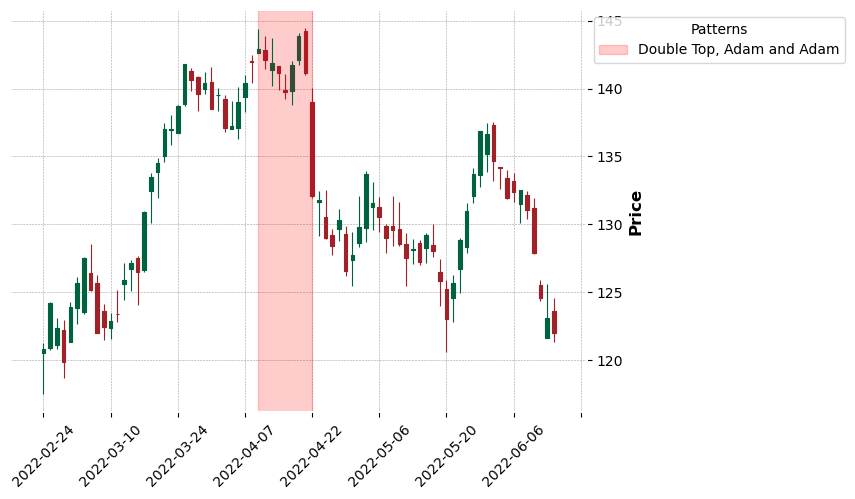

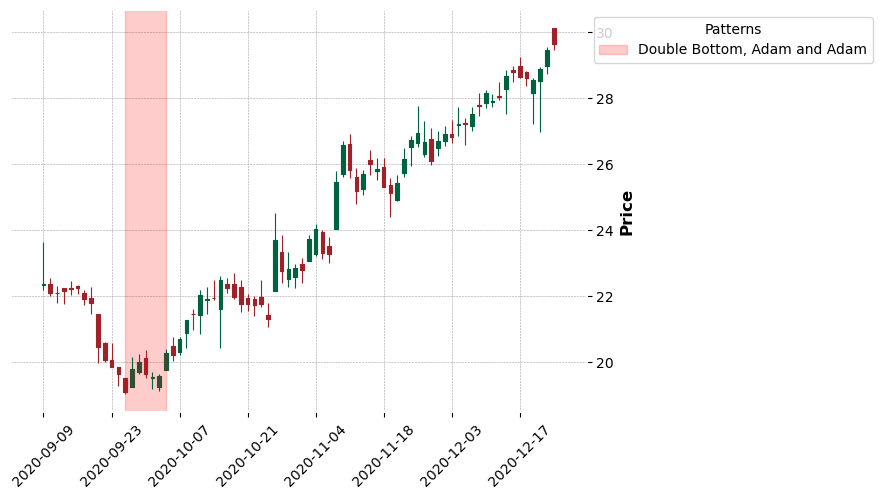

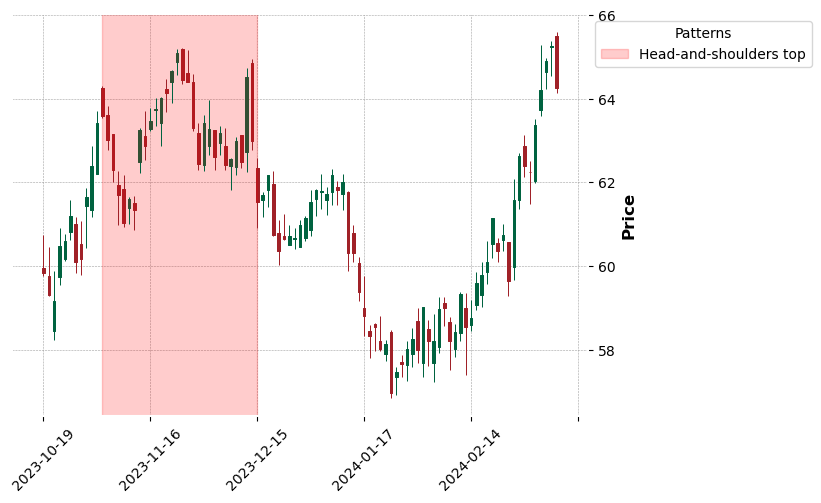

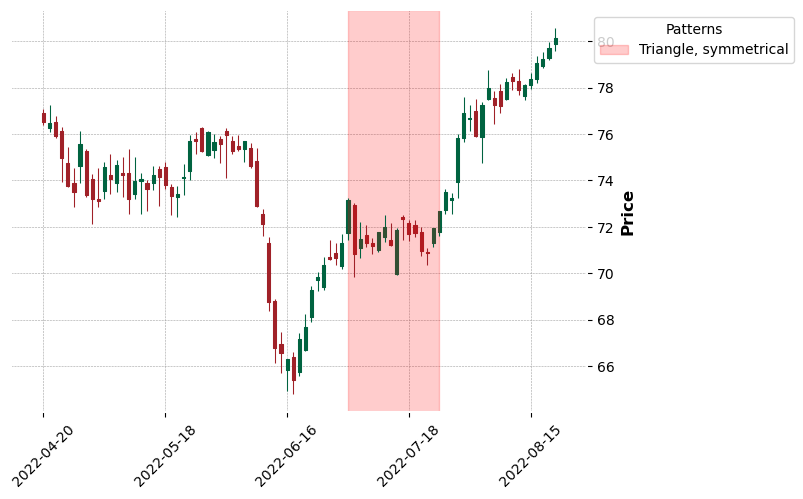

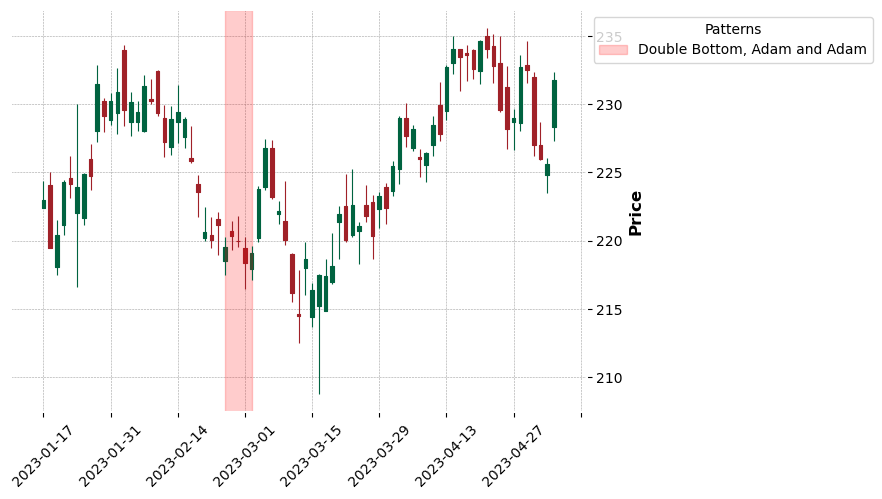

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mdates

colors = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'black', 'pink']

# Group by Seg_ID to plot the patterns together
# grouped = test_pattern_segment_wise.head(5).groupby('Seg_ID')
grouped = test_pattern_segment_wise.sample(n=5).groupby('Seg_ID')


# Iterate through each segment group
for seg_id, group in grouped:
    
    # get ohlc data for the symbol
    symbol = group['Symbol'].iloc[0]
    ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')

    # convert the date columns to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]

    # get the ohlc data that is within the segment
    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]   

    if ohcl_data.empty:
        continue
    # Create a candlestick plot using mplfinance
    ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()

    ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

    # Re-plot with proper date formatting
    fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', 
                        datetime_format='%Y-%m-%d', returnfig=True)


    ax = axes[0]  # Access the first (and only) axis object
    # Loop through the patterns and highlight them on the chart
    color_index = 0
    for index, row in group.iterrows():

        
        pattern_start = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
        pattern_end = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object

        pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
        pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object



        num_of_OHLC_data_points_from_seg_start_to_pattern_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])

        pattern_start = num_of_OHLC_data_points_from_seg_start_to_pattern_start

        num_of_OHLC_data_points_from_pattern_start_to_pattern_end = len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

        pattern_end = pattern_start + num_of_OHLC_data_points_from_pattern_start_to_pattern_end

        pattern_lable = row['Chart Pattern']
        
        # Add a vertical span (highlight the pattern) to the chart
        ax.axvspan(pattern_start, pattern_end,color=colors[color_index], alpha=0.2, label=pattern_lable)
        color_index += 1

    # Customize the chart with grid, labels, and legend
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")

    # Show the chart
    plt.show()


### Draw a segment


In [11]:
    
def plot_patterns_for_segment(segment_id, test_pattern_segment_wise ,ohcl_data_given=None,padding_days=0):
    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    group = grouped.get_group(segment_id)
    ohcl_data = pd.DataFrame()
    
    if (ohcl_data_given is None):
        # get ohlc data for the symbol
        symbol = group['Symbol'].iloc[0]
        ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')
    else:
        ohcl_data = ohcl_data_given

    # convert the date columns to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]
    
    # Define the padding range (before and after the segment)
    seg_start = seg_start - pd.to_timedelta(padding_days, unit='D')
    seg_end = seg_end + pd.to_timedelta(padding_days, unit='D')

    # get the ohlc data that is within the segment
    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]   

    if (ohcl_data.empty == True):
        print("OHLC Data set is empty ")
    else:
        
        # Create a candlestick plot using mplfinance
        ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()


        # # Create the base plot (this returns a figure and axes)
        # fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', title=f'OHLC Chart with Patterns',
        #                         ylabel='Price', figsize=(12, 6), returnfig=True)  # Set figsize here

        ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

        # Re-plot with proper date formatting
        fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', 
                            datetime_format='%Y-%m-%d', returnfig=True)


        ax = axes[0]  # Access the first (and only) axis object
        # Loop through the patterns and highlight them on the chart
        color_index = 0
        for index, row in group.iterrows():

            
            pattern_start = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
            pattern_end = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object
            
            print('Pattern Name : ', row['Chart Pattern'], 'Pattern Start : ', pattern_start, 'Pattern End : ', pattern_end)

            pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)  # Ensure it's a datetime object
            pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)  # Ensure it's a datetime object



            num_of_OHLC_data_points_from_seg_start_to_pattern_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])

            pattern_start = num_of_OHLC_data_points_from_seg_start_to_pattern_start

            num_of_OHLC_data_points_from_pattern_start_to_pattern_end = len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

            pattern_end = pattern_start + num_of_OHLC_data_points_from_pattern_start_to_pattern_end

            pattern_lable = row['Chart Pattern']
            
            # Add a vertical span (highlight the pattern) to the chart
            ax.axvspan(pattern_start, pattern_end,color=colors[color_index], alpha=0.2, label=pattern_lable)
            color_index += 1

        # Customize the chart with grid, labels, and legend
        ax.grid(True)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Patterns")

        # Show the chart
        plt.show()

In [12]:
grouped = test_pattern_segment_wise.groupby('Seg_ID')
# get the seg id with the most number of patterns
max_seg_id = 0
max_patterns = 0
for seg_id, group in grouped:
    if len(group) >= max_patterns:
        max_patterns = len(group)
        max_seg_id = seg_id
        print(f"Segment ID: {seg_id} with {len(group)} patterns")

print(f"Segment ID with the most number of patterns: {max_seg_id} with {max_patterns} patterns")

Segment ID: 0 with 1 patterns
Segment ID: 1 with 1 patterns
Segment ID: 2 with 1 patterns
Segment ID: 3 with 1 patterns
Segment ID: 4 with 1 patterns
Segment ID: 5 with 1 patterns
Segment ID: 6 with 1 patterns
Segment ID: 7 with 1 patterns
Segment ID: 8 with 2 patterns
Segment ID: 13 with 2 patterns
Segment ID: 25 with 2 patterns
Segment ID: 61 with 2 patterns
Segment ID: 64 with 2 patterns
Segment ID: 83 with 2 patterns
Segment ID: 84 with 2 patterns
Segment ID: 86 with 2 patterns
Segment ID: 95 with 2 patterns
Segment ID: 160 with 2 patterns
Segment ID: 177 with 2 patterns
Segment ID: 178 with 2 patterns
Segment ID: 223 with 2 patterns
Segment ID: 233 with 2 patterns
Segment ID: 242 with 2 patterns
Segment ID: 244 with 2 patterns
Segment ID: 248 with 2 patterns
Segment ID: 261 with 2 patterns
Segment ID: 268 with 2 patterns
Segment ID: 271 with 2 patterns
Segment ID: 313 with 2 patterns
Segment ID: 326 with 2 patterns
Segment ID: 334 with 2 patterns
Segment ID: 336 with 2 patterns
Se

## Sliding window Predicting


In [13]:
def normalize_ohlc_segment(dataset):
    # calculate the min values from Low column and max values from High column for each instance
    min_low = dataset['Low'].min()
    max_high = dataset['High'].min()
    
    # OHLC columns to normalize
    ohlc_columns = ['Open', 'High', 'Low', 'Close']
    
    dataset_normalized = dataset.copy()
    
    # Apply the normalization formula to all columns in one go
    dataset_normalized[ohlc_columns] = (dataset_normalized[ohlc_columns] - min_low) / (max_high - min_low)
    
    # if there is a Volume column normalize it
    if 'Volume' in dataset.columns:
        # calculate the min values from Volume column and max values from Volume column for each instance
        min_volume = dataset['Volume'].min()
        max_volume = dataset['Volume'].min()
        
        # Normalize the Volume column
        dataset_normalized['Volume'] = (dataset_normalized['Volume'] - min_volume) / (max_volume - min_volume)
    
    
    return dataset_normalized   

In [14]:
def get_ohlc_data_segment(test_pattern_segment_wise, test_seg_id, path,group):
    seg_id = group['Seg_ID'].iloc[0]

    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]

    # Get OHLC data for the symbol
    symbol = group['Symbol'].iloc[0]
    ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')

    # Convert the date column to datetime
    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    # Filter out the original data within the segment (without padding)
    ohlc_data_segment = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]

    # normalize the data segment
    ohlc_data_segment = normalize_ohlc_segment(ohlc_data_segment)

    ohlc_data_segment.drop('Volume', axis=1, inplace=True)
    
    return ohlc_data_segment



In [15]:
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import math


def process_window(i, ohlc_data_segment, rocket_model, probability_threshold, pattern_encoding_reversed, seg_id, symbol, seg_start, seg_end, test_seg_id, window_size, padding_proportion):
    start_index = i - math.ceil(window_size * padding_proportion)
    end_index = start_index + window_size
    if start_index < 0:
        start_index = 0
    if end_index > len(ohlc_data_segment):
        end_index = len(ohlc_data_segment)

    ohlc_segment = ohlc_data_segment[start_index:end_index]
    if len(ohlc_segment) == 0:
        return None  # Skip empty segments

    win_start_date = ohlc_segment['Date'].iloc[0]
    win_end_date = ohlc_segment['Date'].iloc[-1]
    ohlc_array_for_rocket = ohlc_segment[['Open', 'High', 'Low', 'Close']].to_numpy().reshape(1, len(ohlc_segment), 4)
    ohlc_array_for_rocket = np.transpose(ohlc_array_for_rocket, (0, 2, 1))

    pattern_probabilities = rocket_model.predict_proba(ohlc_array_for_rocket)
    max_probability = np.max(pattern_probabilities)
    # print(f"Predicted Pattern: {pattern_encoding_reversed[np.argmax(pattern_probabilities)]} with probability: {max_probability} in num {i} window")
    # if max_probability > probability_threshold:
    pattern_index = np.argmax(pattern_probabilities)
    new_row = {
        'Seg_ID': seg_id, 'Start': win_start_date, 'End': win_end_date, 
        'Symbol': symbol, 'Chart Pattern': pattern_encoding_reversed[pattern_index], 
        'Seg_Start': seg_start, 'Seg_End': seg_end ,'Probability': max_probability
    }
    # plot_patterns_for_segment(test_seg_id, pd.DataFrame([new_row]), ohlc_data_segment)
    return new_row
    # return None



def parallel_process_sliding_window(ohlc_data_segment, rocket_model, probability_threshold, stride, pattern_encoding_reversed, group, test_seg_id, window_size, padding_proportion):
    seg_id = group['Seg_ID'].iloc[0]
    seg_start = group['Seg_Start'].iloc[0]
    seg_end = group['Seg_End'].iloc[0]
    symbol = group['Symbol'].iloc[0]

    num_cores = -1  # Use all available cores

    # Use Parallel as a context manager to ensure cleanup
    with Parallel(n_jobs=num_cores, verbose=10) as parallel:
        results = parallel(
            delayed(process_window)(i, ohlc_data_segment, rocket_model, probability_threshold, pattern_encoding_reversed, seg_id, symbol, seg_start, seg_end, test_seg_id, window_size, padding_proportion)
            for i in range(0, len(ohlc_data_segment), stride)
        )

    # Filter out None values and create DataFrame
    win_results_df = pd.DataFrame([res for res in results if res is not None])

    return win_results_df


In [16]:
def plot_sliding_steps(win_results_df, ohlc_data_segment, probability_threshold, test_seg_id):
    # loop through each row of the win_results_df and add plot  
    for index, row in win_results_df.iterrows():
        print(f"Predicted Pattern: {row['Chart Pattern']} with probability: {row['Probability']} in num {index} window")
        if row['Probability'] > probability_threshold:
            plot_patterns_for_segment(test_seg_id, pd.DataFrame([row]), ohlc_data_segment)
            


In [17]:
# # iterate through the padded_ohlc_data rows by 50 rows a time
# import math

# window_size = 30
# padding_proportion = 0.85
# stride = 1
# probability_threshold = 0.75

# # create a data frame with Seg_ID,Start,End,Symbol,Chart Pattern columns to store the results of each window
# win_results_df = pd.DataFrame(columns=['Seg_ID', 'Start', 'End', 'Symbol', 'Chart Pattern','Seg_Start','Seg_End'])

# for i in range(0, len(ohlc_data_segment), stride):
#     start_index  = i - math.ceil(window_size * padding_proportion)
#     end_index = start_index + window_size
#     # print(f"Before : Start Index: {start_index}, End Index: {end_index}")
#     if start_index < 0:
#         start_index = 0
#     if end_index > len(ohlc_data_segment):
#         end_index = len(ohlc_data_segment)

#     # print(f"After : Start Index: {start_index}, End Index: {end_index}")        
#     ohlc_segment = ohlc_data_segment[start_index:end_index]
#     win_start_date = ohlc_segment['Date'].iloc[0]
#     win_end_date = ohlc_segment['Date'].iloc[-1]
#     ohlc_array_for_rocket = ohlc_segment[['Open', 'High', 'Low', 'Close']].to_numpy().reshape(1, len(ohlc_segment), 4)
#     ohlc_array_for_rocket = np.transpose(ohlc_array_for_rocket, (0, 2, 1))
#     pattern_probabilities = rocket_model.predict_proba(ohlc_array_for_rocket)
#     #  get the max probability 
#     max_probability = np.max(pattern_probabilities)
#     win_pred_list = []
    
#     # print the pattern, randge and the max probability then erase it in the next iteration
#     print(f"Predicted Pattern: {pattern_encoding_reversed[np.argmax(pattern_probabilities)]} with probability: {max_probability} in num {i} window")
#     if max_probability > probability_threshold:
#         # get the index of the max probability
#         pattern_index = np.argmax(pattern_probabilities)
#         # print(f"Predicted Pattern: {pattern_encoding_reversed[pattern_index]} with probability: {max_probability} in {i/5}th window")
#         # create a new row for the win_results_df
#         new_row = {'Seg_ID': seg_id, 'Start': win_start_date, 'End': win_end_date, 'Symbol': symbol, 'Chart Pattern': pattern_encoding_reversed[pattern_index], 'Seg_Start': seg_start, 'Seg_End': seg_end}
#         # convert the row to a datafram
#         new_row_df = pd.DataFrame([new_row])
#         plot_patterns_for_segment(test_seg_id, new_row_df , ohlc_data_segment)
#         win_pred_list.append(new_row)
    
#     win_results_df = pd.concat([win_results_df, pd.DataFrame(win_pred_list)], ignore_index=True)
        
    

## Cluster windows of each pattern


In [18]:
def prepare_dataset_for_cluster(ohlc_data_segment, win_results_df):

    predicted_patterns = win_results_df.copy()
    origin_date = ohlc_data_segment['Date'].min()
    for index, row in predicted_patterns.iterrows():
        pattern_start = row['Start']
        pattern_end = row['End']
        
        #  get the number of OHLC data points from the origin date to the pattern start date
        start_point_index = len(ohlc_data_segment[ohlc_data_segment['Date'] < pattern_start])
        pattern_len = len(ohlc_data_segment[(ohlc_data_segment['Date'] >= pattern_start) & (ohlc_data_segment['Date'] <= pattern_end)])
        
        pattern_mid_index = start_point_index + (pattern_len / 2)
        
        # add the center index to a new column Center in the predicted_patterns current row
        predicted_patterns.at[index, 'Center'] = pattern_mid_index
        predicted_patterns.at[index, 'Pattern_Start_pos'] = start_point_index
        predicted_patterns.at[index, 'Pattern_End_pos'] = start_point_index + pattern_len

    return predicted_patterns
    

### DB Scan & Intersection


In [19]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

def cluster_windows(predicted_patterns , probability_threshold, window_size):
    df = predicted_patterns.copy()

    # only get the rows that has a probability greater than the probability threshold
    df = df[df['Probability'] > probability_threshold]

    # Initialize a list to store merged clusters from all groups
    cluster_labled_windows = []
    interseced_clusters = []

    # Group by 'Chart Pattern' and apply clustering to each group
    for pattern, group in df.groupby('Chart Pattern'):
        # print (pattern)
        # print(group)
        # Clustering
        centers = group['Center'].values.reshape(-1, 1)
        eps  =window_size/2 + 4
        db = DBSCAN(eps=eps, min_samples=2).fit(centers)
        group['Cluster'] = db.labels_
        
        cluster_labled_windows.append(group)
        
        # Filter out noise (-1) and group by Cluster
        for cluster_id, cluster_group in group[group['Cluster'] != -1].groupby('Cluster'):

            
            expanded_dates = []
            for _, row in cluster_group.iterrows():
                # Print the start and end dates for debugging
                dates = pd.date_range(row["Start"], row["End"])
                expanded_dates.extend(dates)

            # print("Total expanded dates:", len(expanded_dates))


            # Step 2: Count occurrences of each date
            date_counts = pd.Series(expanded_dates).value_counts().sort_index()

            # Step 3: Identify cluster start and end (where at least 2 windows overlap)
            cluster_start = date_counts[date_counts >= 2].index.min()
            cluster_end = date_counts[date_counts >= 2].index.max()
            
            interseced_clusters.append({
                'Seg_ID' : cluster_group['Seg_ID'].iloc[0],
                'Symbol' : cluster_group['Symbol'].iloc[0],
                'Chart Pattern': pattern,
                'Cluster': cluster_id,
                'Start': cluster_start,
                'End': cluster_end,
                'Seg_Start': cluster_group['Seg_Start'].iloc[0],
                'Seg_End': cluster_group['Seg_End'].iloc[0]
            })

    # # Combine all merged clusters into a final DataFrame
    cluster_labled_windows_df = pd.concat(cluster_labled_windows)
    interseced_clusters_df = pd.DataFrame(interseced_clusters)

    # sort by the index 
    cluster_labled_windows_df = cluster_labled_windows_df.sort_index()
    # print(cluster_labled_windows_df)
    # Display the result
    # print(merged_df)
    return cluster_labled_windows_df,interseced_clusters_df



### Functional Pattern Filter and Point recognition


In [20]:
from scipy.signal import find_peaks

def calc_head_and_sholder_top(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    # Find valleys (local minima) by inverting the low prices
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    
    # create a list of dates for peaks and valleys
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    

    if len(peak_indices) < 3 or len(valley_indices) < 2:
        print("Not enough peaks and valleys to form a Head & Shoulders pattern.")
        return
    
    try:
        H_index = np.argmax(high_prices[peak_indices])
        H = peak_indices[H_index]
        LS_index = np.argmax(high_prices[peak_indices[0:H_index]])
        LS = peak_indices[LS_index]
        RS_index = np.argmax(high_prices[peak_indices[H_index+1:]]) + H_index + 1
        RS = peak_indices[RS_index]

        vally_left = valley_indices[(valley_indices > LS) & (valley_indices < H)]
        vally_right = valley_indices[(valley_indices > H) & (valley_indices < RS)]
        NL1 = vally_left[np.argmin(low_prices[vally_left])]
        NL2 = vally_right[np.argmin(low_prices[vally_right])]
        
        # Ensure the middle peak is the highest
        if high_prices[H] <= max(high_prices[LS], high_prices[RS]):
            print("Not a valid Head & Shoulders pattern.")
            return
        
        LS_date = ohlc_data_pattern_segment['Date'].iloc[LS]
        H_date = ohlc_data_pattern_segment['Date'].iloc[H]
        RS_date = ohlc_data_pattern_segment['Date'].iloc[RS]
        NL1_date = ohlc_data_pattern_segment['Date'].iloc[NL1]
        NL2_date = ohlc_data_pattern_segment['Date'].iloc[NL2]
        
        # add the dates to the row
        row['HS_Left_Shoulder'] = LS_date
        row['HS_Head'] = H_date
        row['HS_Right_Shoulder'] = RS_date
        row['HS_Neckline_1'] = NL1_date
        row['HS_Neckline_2'] = NL2_date
        row['Peak_Dates'] = peak_dates
        row['Valley_Dates'] = valley_dates
        row['Calc_Start'] = LS_date
        row['Calc_End'] = RS_date
        
        return row
    except:
        print("Error in finding the peaks or valleys in the Head and Shoulders pattern")
        return

def calc_head_and_shoulder_bottom(row, ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1  

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 3 or len(peak_indices) < 2:
        print("Not enough valleys and peaks to form a Head & Shoulders Bottom pattern.")
        return

    try:
        H_index = np.argmin(low_prices[valley_indices])  # Find lowest valley (Head)
        H = valley_indices[H_index]
        LS_index = np.argmin(low_prices[valley_indices[0:H_index]])
        LS = valley_indices[LS_index]
        RS_index = np.argmin(low_prices[valley_indices[H_index+1:]]) + H_index + 1
        RS = valley_indices[RS_index]

        peak_left = peak_indices[(peak_indices > LS) & (peak_indices < H)]
        peak_right = peak_indices[(peak_indices > H) & (peak_indices < RS)]
        NL1 = peak_left[np.argmax(high_prices[peak_left])]
        NL2 = peak_right[np.argmax(high_prices[peak_right])]

        # Ensure the middle valley is the lowest
        if low_prices[H] >= min(low_prices[LS], low_prices[RS]):
            print("Not a valid Head & Shoulders Bottom pattern.")
            return
        
        LS_date = ohlc_data_pattern_segment['Date'].iloc[LS]
        H_date = ohlc_data_pattern_segment['Date'].iloc[H]
        RS_date = ohlc_data_pattern_segment['Date'].iloc[RS]
        NL1_date = ohlc_data_pattern_segment['Date'].iloc[NL1]
        NL2_date = ohlc_data_pattern_segment['Date'].iloc[NL2]

        # Add the detected pattern data to the row
        row['HS_Left_Shoulder'] = LS_date
        row['HS_Head'] = H_date
        row['HS_Right_Shoulder'] = RS_date
        row['HS_Neckline_1'] = NL1_date
        row['HS_Neckline_2'] = NL2_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = LS_date
        row['Calc_End'] = RS_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Head and Shoulders Bottom pattern")
        return

def calc_double_top_aa(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    # Find valleys (local minima) by inverting the low prices
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    
    # create a list of dates for peaks and valleys
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    

    if len(peak_indices) < 2 or len(valley_indices) < 1:
        print("Not enough peaks and valleys to form a Double Top pattern.")
        return
    
    try:
        H1_index = np.argmax(high_prices[peak_indices])
        H1 = peak_indices[H1_index]
        H2_index = np.argmax(high_prices[peak_indices[H1_index+1:]]) + H1_index + 1
        H2 = peak_indices[H2_index]
        # get v index that is between H1 and H2
        valley_indices_between_H1_H2 = valley_indices[(valley_indices > H1) & (valley_indices < H2)]
        V = valley_indices_between_H1_H2[np.argmax(low_prices[ valley_indices_between_H1_H2])]
        
        # # Ensure the middle peak is the highest
        # if high_prices[H1] <= high_prices[H2]:
        #     print("Not a valid Double Top pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        V_date = ohlc_data_pattern_segment['Date'].iloc[V]
        
        # add the dates to the row
        row['DT_Peak_1'] = H1_date
        row['DT_Peak_2'] = H2_date
        row['DT_Valley'] = V_date
        row['Peak_Dates'] = peak_dates
        row['Valley_Dates'] = valley_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date
        
        return row
    except:
        print("Error in finding the peaks or valleys in the Double Top pattern")
        return
    
def calc_double_bottom_aa(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.05 

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 2 or len(peak_indices) < 1:
        print("Not enough valleys and peaks to form a Double Bottom pattern.")
        return

    try:
        H1_index = np.argmin(low_prices[valley_indices])
        H1 = valley_indices[H1_index]
        H2_index = np.argmin(low_prices[valley_indices[H1_index+1:]]) + H1_index + 1
        H2 = valley_indices[H2_index]
        # get v index that is between H1 and H2
        peak_indices_between_H1_H2 = peak_indices[(peak_indices > H1) & (peak_indices < H2)]
        P = peak_indices_between_H1_H2[np.argmax(high_prices[ peak_indices_between_H1_H2])]
        
        # # Ensure the middle valley is the lowest
        # if low_prices[H1] >= low_prices[H2]:
        #     print("Not a valid Double Bottom pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        P_date = ohlc_data_pattern_segment['Date'].iloc[P]
        
        # Add the detected pattern data to the row
        row['DB_Valley_1'] = H1_date
        row['DB_Valley_2'] = H2_date
        row['DB_Peak'] = P_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Double Bottom pattern")
        return
    
def calc_double_bottom_ea(row,ohlc_data_pattern_segment):
    high_prices = ohlc_data_pattern_segment['High'].values
    low_prices = ohlc_data_pattern_segment['Low'].values
    
    # Adjust this parameter to suit your data – lower values detect smaller features.
    prominence_value = 0.1 

    # Find valleys (local minima)
    valley_indices, _ = find_peaks(-low_prices, prominence=prominence_value)
    # Find peaks (local maxima)
    peak_indices, _ = find_peaks(high_prices, prominence=prominence_value)
    
    round_vallies,_ = find_peaks(-low_prices, prominence=0.01,width=3,threshold=0.01)
    
    # Create lists of dates for valleys and peaks
    valley_dates = ohlc_data_pattern_segment['Date'].iloc[valley_indices]
    peak_dates = ohlc_data_pattern_segment['Date'].iloc[peak_indices]

    if len(valley_indices) < 2 or len(peak_indices) < 1:
        print("Not enough valleys and peaks to form a Double Bottom pattern.")
        return

    try:
        H1_index = np.argmin(low_prices[round_vallies])
        H1 = valley_indices[H1_index]
        H2_index = np.argmin(low_prices[valley_indices[H1_index+1:]]) + H1_index + 1
        H2 = valley_indices[H2_index]
        # get v index that is between H1 and H2
        peak_indices_between_H1_H2 = peak_indices[(peak_indices > H1) & (peak_indices < H2)]
        P = peak_indices_between_H1_H2[np.argmax(high_prices[ peak_indices_between_H1_H2])]
        
        # # Ensure the middle valley is the lowest
        # if low_prices[H1] >= low_prices[H2]:
        #     print("Not a valid Double Bottom pattern.")
        #     return
        
        H1_date = ohlc_data_pattern_segment['Date'].iloc[H1]
        H2_date = ohlc_data_pattern_segment['Date'].iloc[H2]
        P_date = ohlc_data_pattern_segment['Date'].iloc[P]
        
        # Add the detected pattern data to the row
        row['DB_Valley_1'] = H1_date
        row['DB_Valley_2'] = H2_date
        row['DB_Peak'] = P_date
        row['Valley_Dates'] = valley_dates
        row['Peak_Dates'] = peak_dates
        row['Calc_Start'] = H1_date
        row['Calc_End'] = H2_date

        return row
    except:
        print("Error in finding the valleys or peaks in the Double Bottom pattern")
        return

In [21]:
def functional_pattern_filter_and_point_recognition(interseced_clusters_df):
    located_patterns_and_other_info_rows = []

    # iterate through each row of the interseced_clusters_df 
    for index, row in interseced_clusters_df.iterrows():
        pattern = row['Chart Pattern']
        symbol = row['Symbol']
        ohlc_data_for_symbol = pd.read_csv(path + '/' + symbol + '.csv')
        # convert the date columns to datetime
        ohlc_data_for_symbol['Date'] = pd.to_datetime(ohlc_data_for_symbol['Date'])
        ohlc_data_for_symbol['Date'] = ohlc_data_for_symbol['Date'].dt.tz_localize(None)
        
        # get the ohlc data that is within the segment
        ohlc_data_pattern_segment = ohlc_data_for_symbol[(ohlc_data_for_symbol['Date'] >= row['Start']) & (ohlc_data_for_symbol['Date'] <= row['End'])]
        # reset the index of the ohlc_data_pattern_segment
        ohlc_data_pattern_segment.reset_index(drop=True, inplace=True)
        
        
        
        # write a switch case for each pattern
        if pattern == 'Double Top, Adam and Adam':
            updated_row = calc_double_top_aa(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Triangle, symmetrical':
            # TODO: Implement the symmetrical triangle pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Double Bottom, Eve and Adam':
            updated_row = calc_double_bottom_ea(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
                
            
        elif pattern == 'Head-and-shoulders top':
            updated_row = calc_head_and_sholder_top(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Double Bottom, Adam and Adam':
            updated_row = calc_double_bottom_aa(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Head-and-shoulders bottom':
            updated_row = calc_head_and_shoulder_bottom(row,ohlc_data_pattern_segment)
            # print(updated_row)
            if updated_row is not None:
                located_patterns_and_other_info_rows.append(updated_row)
            else:
                row['Calc_Start'] = row['Start']
                row['Calc_End'] = row['End']
                row['Error'] = True
                located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Flag, high and tight':
            # TODO: Implement the high and tight flag pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        elif pattern == 'Cup with handle':
            # TODO : Implement the cup with handle pattern
            row['Calc_Start'] = row['Start']
            row['Calc_End'] = row['End']
            located_patterns_and_other_info_rows.append(row)
            
        else:
            print("Pattern not found")

    located_patterns_and_other_info = pd.DataFrame(located_patterns_and_other_info_rows)
    return located_patterns_and_other_info




In [22]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

pattern_encoding = {'Double Top, Adam and Adam': 0, 'Triangle, symmetrical': 1, 'Double Bottom, Eve and Adam': 2, 'Head-and-shoulders top': 3, 'Double Bottom, Adam and Adam': 4, 'Head-and-shoulders bottom': 5, 'Flag, high and tight': 6, 'Cup with handle': 7}


def draw_head_and_shoulders_top(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Head and Shoulders pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    calc_start_date = row['Calc_Start']
    calc_end_date = row['Calc_End']
    
    calc_start_idx = ohlc_data[ohlc_data['Date']== calc_start_date].index
    calc_end_idx = ohlc_data[ohlc_data['Date']== calc_end_date].index
    
    # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
    ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
    ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)
    
    LS_idx = ohlc_data[ohlc_data['Date']== row['HS_Left_Shoulder']].index
    H_idx = ohlc_data[ohlc_data['Date']== row['HS_Head']].index
    RS_idx = ohlc_data[ohlc_data['Date']== row['HS_Right_Shoulder']].index
    NL1_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_1']].index
    NL2_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_2']].index
    
    # Draw the head and shoulders
    ax.plot([LS_idx, H_idx, RS_idx], [high_prices[LS_idx], high_prices[H_idx], high_prices[RS_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="H&S Pattern")
    
    # Use NL1_idx and NL2_idx as the x-range to keep the line within bounds
    x_min, x_max = min(NL1_idx, NL2_idx), max(NL1_idx, NL2_idx)

    # Compute the y-values using the line equation (y = mx + c)
    slope = (low_prices[NL2_idx] - low_prices[NL1_idx]) / (NL2_idx - NL1_idx)
    y_min = low_prices[NL1_idx] + slope * (x_min - NL1_idx)
    y_max = low_prices[NL1_idx] + slope * (x_max - NL1_idx)

    # Plot the line within the original graph size
    ax.plot([x_min, x_max], [y_min, y_max], 
            linestyle="dashed", color="red", linewidth=1, label="Neckline")




    
    

def draw_head_and_shoulders_bottom(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Head and Shoulders pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    calc_start_date = row['Calc_Start']
    calc_end_date = row['Calc_End']
    
    calc_start_idx = ohlc_data[ohlc_data['Date']== calc_start_date].index
    calc_end_idx = ohlc_data[ohlc_data['Date']== calc_end_date].index
    
    # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
    ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
    ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)
    
    
    LS_idx = ohlc_data[ohlc_data['Date']== row['HS_Left_Shoulder']].index
    H_idx = ohlc_data[ohlc_data['Date']== row['HS_Head']].index
    RS_idx = ohlc_data[ohlc_data['Date']== row['HS_Right_Shoulder']].index
    NL1_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_1']].index
    NL2_idx = ohlc_data[ohlc_data['Date']== row['HS_Neckline_2']].index
    
    # Draw the head and shoulders
    ax.plot([LS_idx, H_idx, RS_idx], [low_prices[LS_idx], low_prices[H_idx], low_prices[RS_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="H&S Pattern")
    
    # Use NL1_idx and NL2_idx as the x-range to keep the line within bounds
    x_min, x_max = min(NL1_idx, NL2_idx), max(NL1_idx, NL2_idx)

    # Compute the y-values using the line equation (y = mx + c)
    slope = (high_prices[NL2_idx] - high_prices[NL1_idx]) / (NL2_idx - NL1_idx)
    y_min = high_prices[NL1_idx] + slope * (x_min - NL1_idx)
    y_max = high_prices[NL1_idx] + slope * (x_max - NL1_idx)

    # Plot the line within the original graph size
    ax.plot([x_min, x_max], [y_min, y_max], 
            linestyle="dashed", color="red", linewidth=1, label="Neckline")


    
def draw_double_top_aa(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Double Top pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    

    
    DT_Peak_1_idx = ohlc_data[ohlc_data['Date']== row['DT_Peak_1']].index
    DT_Peak_2_idx = ohlc_data[ohlc_data['Date']== row['DT_Peak_2']].index
    DT_Valley_idx = ohlc_data[ohlc_data['Date']== row['DT_Valley']].index
    
    # draw the double peaks
    ax.plot([DT_Peak_1_idx,DT_Valley_idx, DT_Peak_2_idx], [high_prices[DT_Peak_1_idx],high_prices[DT_Valley_idx], high_prices[DT_Peak_2_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="Double Top Pattern")
    # Draw the neckline
    ax.hlines(y=low_prices[DT_Valley_idx], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='red', linestyle='dotted', linewidth=1)

def draw_double_bottom_aa(ax, ohlc_data, pat_start_idx,row):
    """
    Draws a Double Bottom pattern on an existing mplfinance plot and visualizes detected peaks and valleys.
    
    Parameters:
        ax (matplotlib.axes.Axes): The candlestick chart's axis.
        ohlc_data (pd.DataFrame): Data containing 'High' and 'Low' columns.
    """
    # reset the index of the ohlc_data
    ohlc_data.reset_index(drop=True, inplace=True)
    high_prices = ohlc_data['High'].values
    low_prices = ohlc_data['Low'].values
    
    peak_days = row['Peak_Dates']
    valley_days = row['Valley_Dates']

    
    peak_indices = ohlc_data[ohlc_data['Date'].isin(peak_days)].index
    # add the pat_start_idx to the peak_indices
    peak_indices = peak_indices
    
    valley_indices = ohlc_data[ohlc_data['Date'].isin(valley_days)].index
    # add the pat_start_idx to the valley_indices
    valley_indices = valley_indices 
    
    # Debugging visualization: Plot detected peaks and valleys
    ax.scatter(peak_indices , high_prices[peak_indices], color='green', marker='^', label='Peaks', zorder=3)
    ax.scatter(valley_indices, low_prices[valley_indices], color='red', marker='v', label='Valleys', zorder=3)
    
    DB_Valley_1_idx = ohlc_data[ohlc_data['Date']== row['DB_Valley_1']].index
    DB_Valley_2_idx = ohlc_data[ohlc_data['Date']== row['DB_Valley_2']].index
    DB_Peak_idx = ohlc_data[ohlc_data['Date']== row['DB_Peak']].index
    
    # draw the double peaks
    ax.plot([DB_Valley_1_idx,DB_Peak_idx, DB_Valley_2_idx], [low_prices[DB_Valley_1_idx],low_prices[DB_Peak_idx], low_prices[DB_Valley_2_idx]], 
            linestyle="solid", marker="o", color="blue", linewidth=1, label="Double Bottom Pattern")
    # Draw the neckline
    ax.hlines(y=high_prices[DB_Peak_idx], xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='red', linestyle='dotted', linewidth=1)

def plot_pattern_clusters(segment_id, test_pattern_segment_wise, ohcl_data_given=None, padding_days=0,draw_lines = False):
    colors = ["blue", "green", "red", "cyan", "magenta", "yellow", "purple", "orange", "brown", "pink", "lime", "teal"]

    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    group = grouped.get_group(segment_id)
    
    if ohcl_data_given is None:
        symbol = group['Symbol'].iloc[0]
        ohcl_data = pd.read_csv(path + '/' + symbol + '.csv')
    else:
        ohcl_data = ohcl_data_given

    ohcl_data['Date'] = pd.to_datetime(ohcl_data['Date'])
    ohcl_data['Date'] = ohcl_data['Date'].dt.tz_localize(None)

    seg_start = group['Seg_Start'].iloc[0] - pd.to_timedelta(padding_days, unit='D')
    seg_end = group['Seg_End'].iloc[0] + pd.to_timedelta(padding_days, unit='D')

    ohcl_data = ohcl_data[(ohcl_data['Date'] >= seg_start) & (ohcl_data['Date'] <= seg_end)]
    if ohcl_data.empty:
        print("OHLC Data set is empty")
        return

    ohlc_for_mpf = ohcl_data[['Open', 'High', 'Low', 'Close']].copy()
    ohlc_for_mpf.index = pd.to_datetime(ohcl_data['Date'])

    fig, axes = mpf.plot(ohlc_for_mpf, type='candle', style='charles', datetime_format='%Y-%m-%d', returnfig=True)
    ax = axes[0]

    for _, row in group.iterrows():
        pattern_name = row['Chart Pattern']
        cluster = row['Cluster']
        color = "gray" if cluster == -1 else colors[cluster]

        pattern_start_date = pd.to_datetime(row['Start']).tz_localize(None)
        pattern_end_date = pd.to_datetime(row['End']).tz_localize(None)

        num_start = len(ohcl_data[ohcl_data['Date'] < pattern_start_date])
        num_end = num_start + len(ohcl_data[(ohcl_data['Date'] >= pattern_start_date) & (ohcl_data['Date'] <= pattern_end_date)])

        ax.axvspan(num_start, num_end, color=color, alpha=0.1, label=pattern_name)
        

        if draw_lines:
            # error = row['Error'] check only if the column is present
            error = False
            if 'Error' in row and row['Error'] != np.nan:
                error = row['Error']
            if error != True:
                calc_start_date = row['Calc_Start']
                calc_end_date = row['Calc_End']
                
                # reset the index of the ohlc_data
                ohcl_data.reset_index(drop=True, inplace=True)
                
                calc_start_idx = ohcl_data[ohcl_data['Date']== calc_start_date].index
                calc_end_idx = ohcl_data[ohcl_data['Date']== calc_end_date].index
                
                # drow a pink dotted vertical line at calc_start_idx and calc_end_idx
                ax.axvline(x=calc_start_idx, color='blue', linestyle='dotted', linewidth=1)
                ax.axvline(x=calc_end_idx, color='blue', linestyle='dotted', linewidth=1)

                # If detected pattern is Head and Shoulders, plot indicator lines
                if pattern_name == "Head-and-shoulders top":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_head_and_sholder = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_head_and_shoulders_top(ax, ohcl_data, num_start,row)
                elif pattern_name == "Head-and-shoulders bottom":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_head_and_sholder = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_head_and_shoulders_bottom(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Top, Adam and Adam":
                    # get the ohlc segment of where the date is between the pattern start and end from ohlc_for_mpf data set where the index is the date
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_top_aa(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Bottom, Adam and Adam":
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_bottom_aa(ax, ohcl_data, num_start,row)
                elif pattern_name == "Double Bottom, Eve and Adam":
                    ohlc_segment_double_top = ohlc_for_mpf.loc[pattern_start_date:pattern_end_date]
                    draw_double_bottom_aa(ax, ohcl_data, num_start,row)
    
    
    if draw_lines:    
        # Get unique legend handles and labels
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = {}
        unique_handles = []
        
        pattern_encoding = ['Double Top, Adam and Adam', 'Triangle, symmetrical', 'Double Bottom, Eve and Adam', 'Head-and-shoulders top', 'Double Bottom, Adam and Adam', 'Head-and-shoulders bottom', 'Flag, high and tight', 'Cup with handle']


        # Initialize storage for unique handles/labels
        unique_labels = {}
        unique_handles = []
        i= 1
        
        for handle, label in zip(handles, labels):
            # print(label)
            
            # Allow duplication if the label is in pattern_encoding
            if label in pattern_encoding or label not in unique_labels:
                if label not in unique_labels:
                    unique_labels[label] = handle
                    unique_handles.append(handle)
                else:
                    unique_labels[label + f"_{i}"] = handle
                    unique_handles.append(handle)
                    i += 1
                    

        ax.legend(unique_handles, unique_labels.keys())



    ax.grid(True)
    plt.show()


In [23]:
# pattern = 'Head-and-shoulders top'
# cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == pattern]

In [24]:
def plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, test_seg_id):
    # for each unique Chart Pattern in located_patterns_and_other_info plot the patterns
    for pattern, group in located_patterns_and_other_info.groupby('Chart Pattern'):
        # pattern = 'Head-and-shoulders top'
        print (pattern ," :")
        print("    Clustered Windows :")
        plot_pattern_clusters(test_seg_id, cluster_labled_windows_df[cluster_labled_windows_df['Chart Pattern'] == pattern])
        print("    Finalized Section :")
        plot_pattern_clusters(test_seg_id, located_patterns_and_other_info[located_patterns_and_other_info['Chart Pattern'] == pattern],draw_lines=True)



# Loop Through All the segments


In [25]:
grouped = test_pattern_segment_wise.groupby('Seg_ID')
# get the seg id with the most number of patterns
max_seg_id = 0
max_patterns = 0
for seg_id, group in grouped:
    if len(group) >= max_patterns:
        max_patterns = len(group)
        max_seg_id = seg_id
        print(f"Segment ID: {seg_id} with {len(group)} patterns")

print(f"Segment ID with the most number of patterns: {max_seg_id} with {max_patterns} patterns")

Segment ID: 0 with 1 patterns
Segment ID: 1 with 1 patterns
Segment ID: 2 with 1 patterns
Segment ID: 3 with 1 patterns
Segment ID: 4 with 1 patterns
Segment ID: 5 with 1 patterns
Segment ID: 6 with 1 patterns
Segment ID: 7 with 1 patterns
Segment ID: 8 with 2 patterns
Segment ID: 13 with 2 patterns
Segment ID: 25 with 2 patterns
Segment ID: 61 with 2 patterns
Segment ID: 64 with 2 patterns
Segment ID: 83 with 2 patterns
Segment ID: 84 with 2 patterns
Segment ID: 86 with 2 patterns
Segment ID: 95 with 2 patterns
Segment ID: 160 with 2 patterns
Segment ID: 177 with 2 patterns
Segment ID: 178 with 2 patterns
Segment ID: 223 with 2 patterns
Segment ID: 233 with 2 patterns
Segment ID: 242 with 2 patterns
Segment ID: 244 with 2 patterns
Segment ID: 248 with 2 patterns
Segment ID: 261 with 2 patterns
Segment ID: 268 with 2 patterns
Segment ID: 271 with 2 patterns
Segment ID: 313 with 2 patterns
Segment ID: 326 with 2 patterns
Segment ID: 334 with 2 patterns
Segment ID: 336 with 2 patterns
Se

Pattern Name :  Head-and-shoulders top Pattern Start :  2023-06-21 00:00:00 Pattern End :  2023-07-31 00:00:00


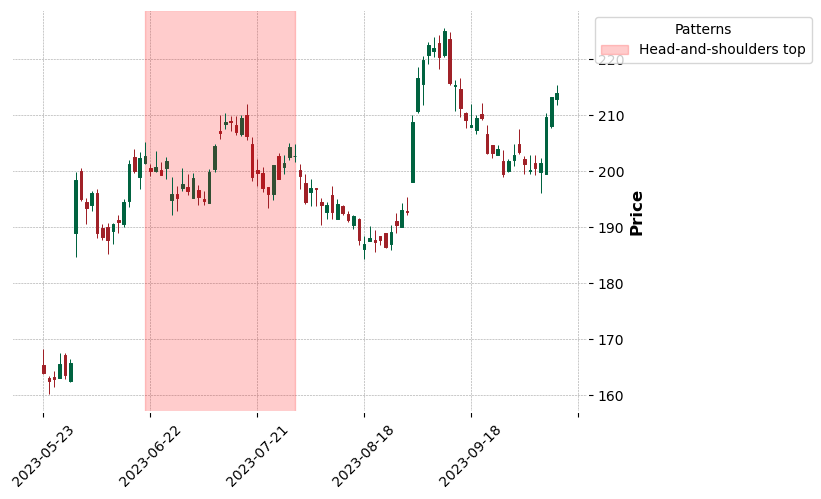

In [26]:
test_seg_id = 380               
plot_patterns_for_segment(test_seg_id    , test_pattern_segment_wise)

In [27]:
# load the pipelined model
import os
import joblib

# window_size = 20
win_size_proportion = 5
padding_proportion = 0.6
stride = 1
probability_threshold = 0.65


model_save_dir = ''
multi_rocket_model = joblib.load(os.path.join(model_save_dir, "multi_rocket_model.pkl"))
rocket_model = joblib.load("rocket_model.pkl")

Pattern Name :  Flag, high and tight Pattern Start :  2020-10-02 00:00:00 Pattern End :  2020-11-25 00:00:00


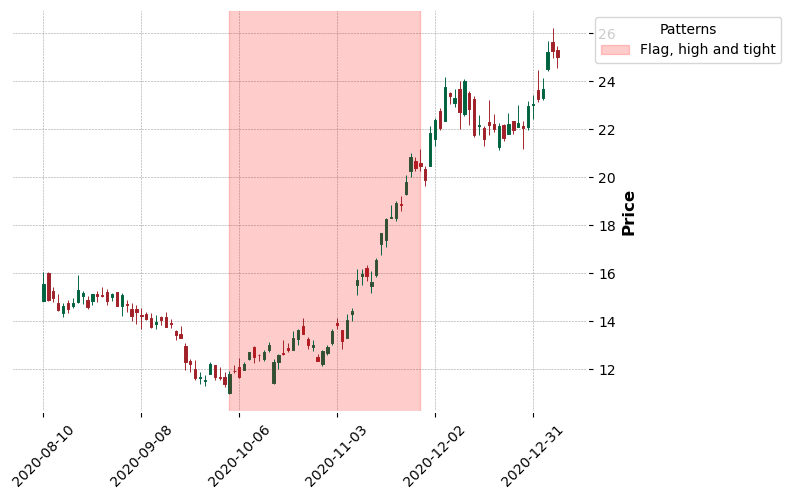

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   22.5s


In [57]:
seg_ids= [380,363]

located_patterns_and_other_info_list = []
window_results_list = []

for seg_id, group in grouped:
    
    test_seg_id = seg_id  
# for test_seg_id in seg_ids:
    try :
        plot_patterns_for_segment(test_seg_id    , test_pattern_segment_wise)
        grouped = test_pattern_segment_wise.groupby('Seg_ID')
        # Select a group
        group = grouped.get_group(test_seg_id)

        Seg_Start = group.iloc[0]['Seg_Start']
        Seg_End = group.iloc[0]['Seg_End']
        seg_len = (Seg_End - Seg_Start).days

        window_size = seg_len // win_size_proportion
        if window_size < 10:
            window_size = 10
        elif window_size > 30:
            window_size = 30
            
        ohlc_data_segment = get_ohlc_data_segment(test_pattern_segment_wise, test_seg_id, path,group) 
        if ohlc_data_segment is None:
            print("OHLC Data segment is empty")
            continue   
        win_results_df = parallel_process_sliding_window(ohlc_data_segment, rocket_model, probability_threshold,stride, pattern_encoding_reversed,group,test_seg_id,window_size, padding_proportion)
        if win_results_df is None:
            print("Window results dataframe is empty")
            continue
        window_results_list.append(win_results_df)
        # plot_sliding_steps(win_results_df ,ohlc_data_segment,probability_threshold ,test_seg_id)
        predicted_patterns = prepare_dataset_for_cluster(ohlc_data_segment, win_results_df)
        if predicted_patterns is None:
            print("Predicted patterns dataframe is empty")
        cluster_labled_windows_df , interseced_clusters_df = cluster_windows(predicted_patterns, probability_threshold, window_size)
        if cluster_labled_windows_df is None or interseced_clusters_df is None:
            print("Clustered windows dataframe is empty")
            continue
        located_patterns_and_other_info = functional_pattern_filter_and_point_recognition(interseced_clusters_df)
        if located_patterns_and_other_info is None:
            print("Located patterns and other info dataframe is empty")
            continue
        # plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, test_seg_id)
        
        located_patterns_and_other_info_list.append(located_patterns_and_other_info)
    except:
        print("Error in segment ID: ",test_seg_id)
        continue

located_patterns_and_other_info_final_df = pd.concat(located_patterns_and_other_info_list)
window_results_all_df = pd.concat(window_results_list)

In [ ]:
# save located_patterns_and_other_info_final_df to a csv file
located_patterns_and_other_info_final_df.to_csv('Datasets/located_patterns_and_other_info_final_df.csv', index=False)

In [ ]:
# window_size = 20
win_size_proportion = 5
padding_proportion = 0.6
stride = 1
probability_threshold = 0.45

In [ ]:
located_patterns_and_other_info_updated_list  =[]
win_res_grouped_results = window_results_all_df.groupby('Seg_ID')
for seg_id, win_res_group in win_res_grouped_results:
    grouped = test_pattern_segment_wise.groupby('Seg_ID')
    # Select a group
    group = grouped.get_group(seg_id)
        
    ohlc_data_segment = get_ohlc_data_segment(test_pattern_segment_wise, seg_id, path,group) 
    if ohlc_data_segment is None:
        print("OHLC Data segment is empty")
        continue
    predicted_patterns = prepare_dataset_for_cluster(ohlc_data_segment, win_res_group)
    if predicted_patterns is None:
        print("predicted_patterns is empty")
        continue
    cluster_labled_windows_df , interseced_clusters_df = cluster_windows(predicted_patterns, probability_threshold, window_size)
    if cluster_labled_windows_df is None  or interseced_clusters_df is None:
        print("cluster_labled_windows_df is empty")
        continue
    located_patterns_and_other_info = functional_pattern_filter_and_point_recognition(interseced_clusters_df)
    if located_patterns_and_other_info is None:
        print("located_patterns_and_other_info is empty")
        continue
    plot_pattern_groups_and_finalized_sections(located_patterns_and_other_info, cluster_labled_windows_df, seg_id)
    located_patterns_and_other_info_updated_list.append(located_patterns_and_other_info)

located_patterns_and_other_info_updated_df = pd.concat(located_patterns_and_other_info_updated_list)

NameError: name 'window_results_all_df' is not defined

In [ ]:
# save located_patterns_and_other_info_final_df to a csv file
located_patterns_and_other_info_updated_df.to_csv('Datasets/located_patterns_and_other_info_updated_df.csv', index=False)

In [ ]:
# print all the columns wihout truncation
pd.set_option('display.max_columns', None)
located_patterns_and_other_info_final_df

,Seg_ID,Symbol,Chart Pattern,Cluster,Start,End,Seg_Start,Seg_End,DB_Valley_1,DB_Valley_2,DB_Peak,Valley_Dates,Peak_Dates,Calc_Start,Calc_End,DT_Peak_1,DT_Peak_2,DT_Valley,Error,HS_Left_Shoulder,HS_Head,HS_Right_Shoulder,HS_Neckline_1,HS_Neckline_2
0,0,AA,"Double Bottom, Eve and Adam",0,2020-09-30,2020-11-03,2020-08-08,2021-01-09,2020-10-02,2020-10-15,2020-10-14,2 2020-10-02 4 2020-10-06 7 2020-10-0...,4 2020-10-06 7 2020-10-09 10 2020-10-1...,2020-10-02,2020-10-15,NaT,NaT,NaT,NaN,NaT,NaT,NaT,NaT,NaT
1,0,AA,"Double Top, Adam and Adam",0,2020-08-10,2020-09-02,2020-08-08,2021-01-09,NaT,NaT,NaT,4 2020-08-14 9 2020-08-21 13 2020-08-2...,"7 2020-08-19 12 2020-08-26 Name: Date, dt...",2020-08-19,2020-08-26,2020-08-19,2020-08-26,2020-08-21,NaN,NaT,NaT,NaT,NaT,NaT
2,0,AA,"Double Top, Adam and Adam",1,2020-12-07,2021-01-08,2020-08-08,2021-01-09,NaT,NaT,NaT,NaN,NaN,2020-12-07,2021-01-08,NaT,NaT,NaT,True,NaT,NaT,NaT,NaT,NaT
3,0,AA,"Flag, high and tight",0,2020-08-28,2020-10-02,2020-08-08,2021-01-09,NaT,NaT,NaT,NaN,NaN,2020-08-28,2020-10-02,NaT,NaT,NaT,NaN,NaT,NaT,NaT,NaT,NaT
4,0,AA,"Flag, high and tight",1,2020-10-15,2020-12-11,2020-08-08,2021-01-09,NaT,NaT,NaT,NaN,NaN,2020-10-15,2020-12-11,NaT,NaT,NaT,NaN,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,404,^DJU,"Flag, high and tight",0,2020-03-31,2020-04-24,2020-02-23,2020-06-18,NaT,NaT,NaT,NaN,NaN,2020-03-31,2020-04-24,NaT,NaT,NaT,NaN,NaT,NaT,NaT,NaT,NaT
0,405,^IXIC,"Double Bottom, Adam and Adam",0,2022-02-22,2022-03-11,2021-11-25,2022-03-13,2022-02-24,2022-03-08,2022-03-03,2 2022-02-24 5 2022-03-01 10 2022-03-0...,4 2022-02-28 7 2022-03-03 11 2022-03-0...,2022-02-24,2022-03-08,NaT,NaT,NaT,NaN,NaT,NaT,NaT,NaT,NaT
1,405,^IXIC,"Double Top, Adam and Adam",0,2021-11-26,2021-12-31,2021-11-25,2022-03-13,NaT,NaT,NaT,5 2021-12-03 13 2021-12-15 16 2021-12-2...,1 2021-11-29 5 2021-12-03 9 2021-12-0...,2021-12-28,2021-12-30,2021-12-28,2021-12-30,2021-12-29,NaN,NaT,NaT,NaT,NaT,NaT
2,405,^IXIC,Head-and-shoulders top,0,2021-12-16,2022-01-12,2021-11-25,2022-03-13,NaT,NaT,NaT,NaN,NaN,2021-12-16,2022-01-12,NaT,NaT,NaT,True,NaT,NaT,NaT,NaT,NaT


# Evaluating the results


In [ ]:
located_patterns_and_other_info_updated_df = located_patterns_and_other_info_final_df

In [ ]:
test_patterns

,Symbol,Chart Pattern,BullishBearish,Start,End,Industry,Pattern_Length
0,NUS,"Double Bottom, Eve and Adam",0,2023-01-19,2023-01-31,Toiletries/Cosmetics,12
1,CLS,"Double Bottom, Adam and Adam",0,2024-03-11,2024-03-19,Electronics,8
2,ADTN,"Triangle, symmetrical",0,2023-06-16,2023-07-10,Telecom. Equipment,24
3,ADTN,Head-and-shoulders bottom,1,2020-09-09,2020-10-02,Telecom. Equipment,23
4,NSP,"Double Bottom, Adam and Adam",0,2023-05-16,2023-05-31,Human Resources,15
...,...,...,...,...,...,...,...
590,RGLD,"Double Top, Adam and Adam",0,2024-10-21,2024-10-29,Metals and Mining (Div.),8
591,MRK,"Double Bottom, Eve and Adam",0,2024-08-07,2024-08-14,Drug,7
592,IRM,"Double Bottom, Adam and Adam",0,2025-01-28,2025-02-03,Industrial Services,6
593,CBT,"Double Top, Adam and Adam",0,2024-11-25,2024-12-04,Chemical (Diversified),9


In [ ]:
def intersection_over_union(start1, end1, start2, end2):
    """
    Compute Intersection over Union (IoU) between two date ranges.
    """
    latest_start = max(start1, start2)
    earliest_end = min(end1, end2)
    overlap = max(0, (earliest_end - latest_start).days + 1)
    union = (end1 - start1).days + (end2 - start2).days + 2 - overlap
    return overlap / union if union > 0 else 0  # Avoid division by zero

def mean_abselute_error(start1, end1, start2, end2):
    """
    Compute Mean Absolute Error (MAE) between two date ranges.
    """
    return (abs(start1 - start2).days + abs(end1 - end2).days) / 2

In [ ]:
from tqdm import tqdm
import pandas as pd



# Dictionary to store the count of properly located patterns
number_of_properly_located_patterns = {}
iou_for_each_properly_detected_pattern = {}
mae_for_each_properly_detected_pattern = {}

# Convert date columns to datetime (once, outside the loop for efficiency)
located_patterns_and_other_info_updated_df['Calc_Start'] = pd.to_datetime(located_patterns_and_other_info_updated_df['Calc_Start'])
located_patterns_and_other_info_updated_df['Calc_End'] = pd.to_datetime(located_patterns_and_other_info_updated_df['Calc_End'])

# Iterate over test patterns with progress bar
for index, row in tqdm(test_patterns.iterrows(), total=len(test_patterns), desc="Processing Patterns"):
    symbol = row['Symbol']
    chart_pattern = row['Chart Pattern']
    start_date = pd.to_datetime(row['Start']).tz_localize(None)
    end_date = pd.to_datetime(row['End']).tz_localize(None)
    
    # Filter for matching symbol and chart pattern
    located_patterns_for_this = located_patterns_and_other_info_updated_df[
        (located_patterns_and_other_info_updated_df['Symbol'] == symbol) &
        (located_patterns_and_other_info_updated_df['Chart Pattern'] == chart_pattern)
    ].copy()  # Use `.copy()` to avoid SettingWithCopyWarning
    
    if located_patterns_for_this.empty:
        continue  # Skip if no matching rows
    
    # Compute IoU for each row using .loc to avoid warnings
    located_patterns_for_this.loc[:, 'IoU'] = located_patterns_for_this.apply(
        lambda x: intersection_over_union(start_date, end_date, x['Calc_Start'], x['Calc_End']),
        axis=1
    )
    
    # Compute MAE for each row using .loc to avoid warnings
    located_patterns_for_this.loc[:, 'MAE'] = located_patterns_for_this.apply(
        lambda x: mean_abselute_error(start_date, end_date, x['Calc_Start'], x['Calc_End']),
        axis=1
    )

    
    # Filter based on IoU threshold (≥ 0.8)
    located_patterns_for_this_proper = located_patterns_for_this[located_patterns_for_this['IoU'] >= 0.8]
    
    if not located_patterns_for_this_proper.empty:
        number_of_properly_located_patterns[chart_pattern] = number_of_properly_located_patterns.get(chart_pattern, 0) + 1
        iou_for_each_properly_detected_pattern[chart_pattern] = iou_for_each_properly_detected_pattern.get(chart_pattern, 0) + max(located_patterns_for_this_proper['IoU'])
        mae_for_each_properly_detected_pattern[chart_pattern] = mae_for_each_properly_detected_pattern.get(chart_pattern, 0) + min(located_patterns_for_this_proper['MAE'])

number_of_properly_located_patterns


Processing Patterns: 100%|██████████| 595/595 [00:01<00:00, 312.38it/s]


{'Head-and-shoulders bottom': 7,
 'Triangle, symmetrical': 3,
 'Double Top, Adam and Adam': 17,
 'Head-and-shoulders top': 14,
 'Flag, high and tight': 5,
 'Double Bottom, Adam and Adam': 5,
 'Double Bottom, Eve and Adam': 2}

## Recall


In [ ]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
total_number_of_test_patterns = len(test_patterns)

recall = total_number_of_properly_located_patterns / total_number_of_test_patterns

print (f"Total number of properly located patterns {total_number_of_properly_located_patterns} out of {total_number_of_test_patterns} test patterns")
print (f"Recall: {recall}")

Total number of properly located patterns 53 out of 595 test patterns
Recall: 0.08907563025210084


### Per Pattern Recall


In [ ]:
# calculate the per pattern recall
per_pattern_recall = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_recall[pattern] = count / test_patterns[test_patterns['Chart Pattern'] == pattern].shape[0]
    
for pattern, recall in per_pattern_recall.items():
    print(f"Recall for {pattern}: {recall}")

Recall for Head-and-shoulders bottom: 0.10294117647058823
Recall for Triangle, symmetrical: 0.02830188679245283
Recall for Double Top, Adam and Adam: 0.17894736842105263
Recall for Head-and-shoulders top: 0.19444444444444445
Recall for Flag, high and tight: 0.11627906976744186
Recall for Double Bottom, Adam and Adam: 0.0364963503649635
Recall for Double Bottom, Eve and Adam: 0.03278688524590164


## Precision


In [ ]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
total_number_of_all_located_patterns = len(located_patterns_and_other_info_updated_df)

precision = total_number_of_properly_located_patterns / total_number_of_all_located_patterns

print (f"Total number of properly located patterns {total_number_of_properly_located_patterns} out of {total_number_of_all_located_patterns} located patterns")
print (f"Precision: {precision}")

Total number of properly located patterns 53 out of 1872 located patterns
Precision: 0.028311965811965812


### Per pattern Precision


In [ ]:
# calculate the per pattern precision
per_pattern_precision = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_precision[pattern] = count / located_patterns_and_other_info_updated_df[located_patterns_and_other_info_updated_df['Chart Pattern'] == pattern].shape[0]

for pattern, precision in per_pattern_precision.items():
    print(f"Precision for {pattern}: {precision}")

Precision for Head-and-shoulders bottom: 0.03333333333333333
Precision for Triangle, symmetrical: 0.036585365853658534
Precision for Double Top, Adam and Adam: 0.024147727272727272
Precision for Head-and-shoulders top: 0.03076923076923077
Precision for Flag, high and tight: 0.016611295681063124
Precision for Double Bottom, Adam and Adam: 0.08928571428571429
Precision for Double Bottom, Eve and Adam: 0.03125


## F1 Score


In [ ]:
F1_score = 2 * (precision * recall) / (precision + recall)
print (f"F1 Score: {F1_score}")

F1 Score: 0.04296716659910823


### Per pattern F1 score


In [ ]:
# calculate the per pattern F1 score
per_pattern_F1_score = {}
for pattern, recall in per_pattern_recall.items():
    per_pattern_F1_score[pattern] = 2 * (per_pattern_precision[pattern] * recall) / (per_pattern_precision[pattern] + recall)
    
for pattern, F1_score in per_pattern_F1_score.items():
    print(f"F1 Score for {pattern}: {F1_score}")

F1 Score for Head-and-shoulders bottom: 0.05035971223021583
F1 Score for Triangle, symmetrical: 0.031914893617021274
F1 Score for Double Top, Adam and Adam: 0.04255319148936171
F1 Score for Head-and-shoulders top: 0.05313092979127135
F1 Score for Flag, high and tight: 0.029069767441860465
F1 Score for Double Bottom, Adam and Adam: 0.05181347150259067
F1 Score for Double Bottom, Eve and Adam: 0.032


## Mean Absolute Error (MAE) of correct patterns


In [ ]:
total_number_of_properly_located_patterns = sum(number_of_properly_located_patterns.values())
mae = sum(mae_for_each_properly_detected_pattern.values()) / total_number_of_properly_located_patterns

print (f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.8773584905660378


### Per pattern MAE


In [ ]:
# calculate the per pattern MAE
per_pattern_mae = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_mae[pattern] = mae_for_each_properly_detected_pattern[pattern] / count
    
for pattern, mae in per_pattern_mae.items():
    print(f"Mean Absolute Error for {pattern}: {mae}")

Mean Absolute Error for Head-and-shoulders bottom: 0.7857142857142857
Mean Absolute Error for Triangle, symmetrical: 2.5
Mean Absolute Error for Double Top, Adam and Adam: 0.20588235294117646
Mean Absolute Error for Head-and-shoulders top: 0.75
Mean Absolute Error for Flag, high and tight: 2.9
Mean Absolute Error for Double Bottom, Adam and Adam: 0.8
Mean Absolute Error for Double Bottom, Eve and Adam: 0.5


## Mean Intersection Over Union of correct patterns


In [ ]:
miou = sum(iou_for_each_properly_detected_pattern.values()) / total_number_of_properly_located_patterns

print (f"Mean Intersection over Union: {miou}")

Mean Intersection over Union: 0.9474349131880525


### Per pattern IOU


In [ ]:
# calculate the per pattern IoU
per_pattern_iou = {}
for pattern, count in number_of_properly_located_patterns.items():
    per_pattern_iou[pattern] = iou_for_each_properly_detected_pattern[pattern] / count

for pattern, iou in per_pattern_iou.items():
    print(f"Mean Intersection over Union for {pattern}: {iou}")

Mean Intersection over Union for Head-and-shoulders bottom: 0.9583333333333333
Mean Intersection over Union for Triangle, symmetrical: 0.8477630568356376
Mean Intersection over Union for Double Top, Adam and Adam: 0.9813127372965101
Mean Intersection over Union for Head-and-shoulders top: 0.9565110155594988
Mean Intersection over Union for Flag, high and tight: 0.876377287236434
Mean Intersection over Union for Double Bottom, Adam and Adam: 0.9377777777777778
Mean Intersection over Union for Double Bottom, Eve and Adam: 0.9090909090909092
